In [16]:
#double tbSim(n, channel) ;
#double tbObs(n, channel) ;
#int64 pType(n) ;
#float sfcEmiss(n, channel) ;
#float skTemp(n) ;
#skTemp:_FillValue = NaNf ;
#double wvp(n) ;
#double iwp(n) ;
#double rwp(n) ;

import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

with nc.Dataset("/Volumes/T7 Shield/SUBSETS/output/training_dataset_land_2d_60to120.nc") as f:
    tbSim = f.variables["tbConv"][:]
    tbObs = f.variables["tbObs"][:]
    pType = f.variables["pType"][:]
    sfcEmiss = f.variables["sfcEmiss"][:]
    skTemp = f.variables["skTemp"][:]
    wvp = f.variables["wvp"][:]
    iwp = f.variables["iwp"][:]
    rwp = f.variables["rwp"][:]
    sfcBin= f.variables["sfcBin"][:]

In [15]:
print(tbSim.mean(axis=0))

[[[1.95445507e+01 1.82425330e+01 4.44831377e+00 4.21777634e+00
   2.53577593e+00 2.11753084e+00 2.03075470e+00 2.70416438e-05
   2.69318164e-05]
  [1.95527766e+01 1.82560554e+01 4.44988904e+00 4.22051063e+00
   2.53637558e+00 2.11806063e+00 2.03180116e+00 2.70422808e-05
   2.69378670e-05]
  [1.95571244e+01 1.82633245e+01 4.45062132e+00 4.22182109e+00
   2.53664474e+00 2.11828336e+00 2.03226482e+00 2.70424275e-05
   2.69400401e-05]
  [1.95565452e+01 1.82626496e+01 4.45027945e+00 4.22131804e+00
   2.53649129e+00 2.11811515e+00 2.03198853e+00 2.70418851e-05
   2.69373862e-05]
  [1.95507229e+01 1.82535432e+01 4.44886403e+00 4.21900363e+00
   2.53593623e+00 2.11757312e+00 2.03099810e+00 2.70411449e-05
   2.69310049e-05]
  [1.95402201e+01 1.82369228e+01 4.44657609e+00 4.21522143e+00
   2.53506390e+00 2.11673546e+00 2.02944898e+00 2.70398593e-05
   2.69218802e-05]
  [1.95261122e+01 1.82145404e+01 4.44367304e+00 4.21041163e+00
   2.53396742e+00 2.11569124e+00 2.02751513e+00 2.70378044e-05
   2

6.388173580169678
77.44548797607422


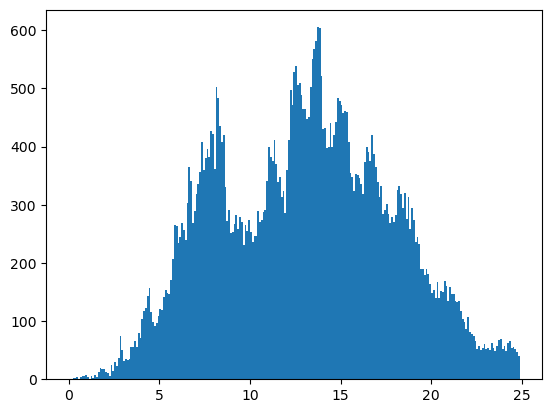

In [11]:
print(rwp.max())
print(iwp.max())
a=np.where(rwp>0)
#h1=plt.hist(rwp[a], bins=50)
b=np.where(iwp>0)
#h2=plt.hist(wvp[b]*1e3, bins=np.arange(0, 25, 0.1))

In [17]:
#normalize tbObs using scaler from sklearn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(tbObs.shape)
scaler.fit(tbObs[:,4,3,:])


(2595084, 9, 7, 9)


StandardScaler()

In [18]:
import pickle
try:
    del tbObs
    with open("tbobs_60_120.scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
except:
    print("tbObs already deleted")
tbSim_scaled = tbSim[:,:,:,:9].copy()
for i in range(9):
    tbSim_scaled[:,:,:,i] = (tbSim_scaled[:,:,:,i] - scaler.mean_[i])/scaler.scale_[i]


In [19]:
gVars=np.concatenate((sfcEmiss[:,:13], (skTemp-273.15)[:,np.newaxis]/1.5, np.log(1+wvp*1e3/10)[:,np.newaxis], np.log(1+iwp/10)[:,np.newaxis], np.log(1+rwp/10)[:,np.newaxis]), axis=1)
#with nc.Dataset("training_dataset_land_2d.nc") as f:
#    sfcBin=f.variables["sfcBin"][:]
try:
    sfcBin_scaled=(88-sfcBin)/30
    del sfcBin
except:
    print("sfcBin already deleted")

x_forward=np.concatenate((tbSim_scaled, sfcBin_scaled[:,:,:,np.newaxis]), axis=3)
#print(sfcBin.max(), sfcBin.min(), sfcBin.shape)

In [20]:
# define convolutional neural network to predict gvars from x_forward

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def cnn_model(nout):
    model = keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(9, 7, 10)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    #model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(nout))
    return model

def cnn_model_logit(nout):
    model = keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(9, 7, 10)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    #model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(nout), activation='softmax')
    return model

forward_model_logit=cnn_model_logit(1)
#forward_modeli=cnn_model(gVars.shape[1])

#print(forward_modeli.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 7, 5, 32)          2912      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 3, 2, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 2, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [21]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(x_forward, gVars, test_size=0.2, random_state=42)
# split the data into training and testing, with first 80% as training and last 20% as testing
X_train=x_forward[:int(0.8*x_forward.shape[0])]
X_test=x_forward[int(0.8*x_forward.shape[0]):]
y_train=gVars[:int(0.8*gVars.shape[0])]
y_test=gVars[int(0.8*gVars.shape[0]):]


In [22]:
forward_modeli.compile(optimizer='adam', loss='mean_squared_error')
history = forward_modeli.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
64878/64878 [==============================] - 138s 2ms/step - loss: 0.1550 - val_loss: 0.1222
Epoch 2/10
64878/64878 [==============================] - 129s 2ms/step - loss: 0.0982 - val_loss: 0.1598
Epoch 3/10
64878/64878 [==============================] - 130s 2ms/step - loss: 0.0840 - val_loss: 0.1080
Epoch 4/10
64878/64878 [==============================] - 133s 2ms/step - loss: 0.0759 - val_loss: 0.1022
Epoch 5/10
64878/64878 [==============================] - 129s 2ms/step - loss: 0.0708 - val_loss: 0.0943
Epoch 6/10
64878/64878 [==============================] - 129s 2ms/step - loss: 0.0672 - val_loss: 0.1073
Epoch 7/10
64878/64878 [==============================] - 132s 2ms/step - loss: 0.0645 - val_loss: 0.1080
Epoch 8/10
64878/64878 [==============================] - 134s 2ms/step - loss: 0.0623 - val_loss: 0.0948
Epoch 9/10
64878/64878 [==============================] - 138s 2ms/step - loss: 0.0603 - val_loss: 0.0947
Epoch 10/10
64878/64878 [=====================

In [24]:
#history = model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
#y_pred=forward_modeli.predict(X_test)
for i in range(0,13):
    print(i,np.corrcoef(y_pred[:,i], y_test[:,i])[0,1])
forward_modeli.save("forward_model_convTb_60_120.h5")

0 0.93928830490602
1 0.9470599484735266
2 0.9393543985943081
3 0.9513124492369966
4 0.9253004510613526
5 0.919695026231205
6 0.9516234707966688
7 0.8665356922687809
8 0.9264607338605849
9 0.7953204429569991
10 0.8908369526613121
11 0.7953215122137324
12 0.7953215230508398


/Users/mgrecu/miniconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
y_pred=forward_model.predict(X_test)
for i in range(0,13):
    print(i,np.corrcoef(y_pred[:,i], y_test[:,i])[0,1])

16220/16220 [==============================] - 9s 567us/step
0 0.9544457480132158
1 0.9701451943942454
2 0.952660119363961
3 0.9698053163888835
4 0.9440678276683427
5 0.9395266805501635
6 0.9669406808146099
7 0.8889461150602018
8 0.9551732473943823
9 0.8390881438061667
10 0.9180953430703173
11 0.8390881519277223
12 0.8390881286894252


In [18]:
forward_modeli.save("forward_model_60to120_noover_10iters.h5")